# Pandas 데모 - Explarotary Data Analysis
## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2                  
%matplotlib inline    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)         #그림 사이즈 지정
plt.style.use('fivethirtyeight')             #그림 기본 스타일
pd.set_option('max_columns', 100)            #칼럼 100개 허용
pd.set_option("display.precision", 4)        #소수점 4자리허용
warnings.simplefilter('ignore')              #경고분 무시

## 데이터 경로

In [2]:
data_dir = Path('C:\\Users\\USER\\Desktop\\Dataset\\DataInput')
trn_file = data_dir / 'trainset.csv'
tst_file = data_dir / 'testset.csv'
feature_file = data_dir / 'feature.csv'
seed = 150

## EDA
### 학습데이터 로드

In [3]:
trn = pd.read_csv(trn_file,header=None)

In [4]:
print(trn.shape)                             #(4280, 32) 첫 컬럼=종속
trn.head()                                   #위에서 5줄 출력

(4280, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,HI,188,128,95,114,143,108,88,103,113,85,88,113,87,88,103,87,84,99,104,82,96,100,78,70,79,84,66,70,75,76,63
1,PH,174,112,88,104,119,92,74,79,88,74,67,90,68,71,73,68,71,77,90,67,71,82,65,70,75,89,73,67,71,89,73
2,GR,175,138,106,105,135,109,75,95,113,96,74,112,96,70,87,100,66,83,117,67,88,110,98,67,88,119,98,75,91,110,94
3,PH,176,111,80,106,131,96,76,99,104,85,75,89,75,79,91,75,84,103,109,82,91,96,78,78,91,96,78,82,104,112,85
4,EL,182,144,111,100,151,119,67,106,114,90,76,115,94,68,106,91,68,102,115,71,95,108,88,71,103,113,92,68,107,118,92


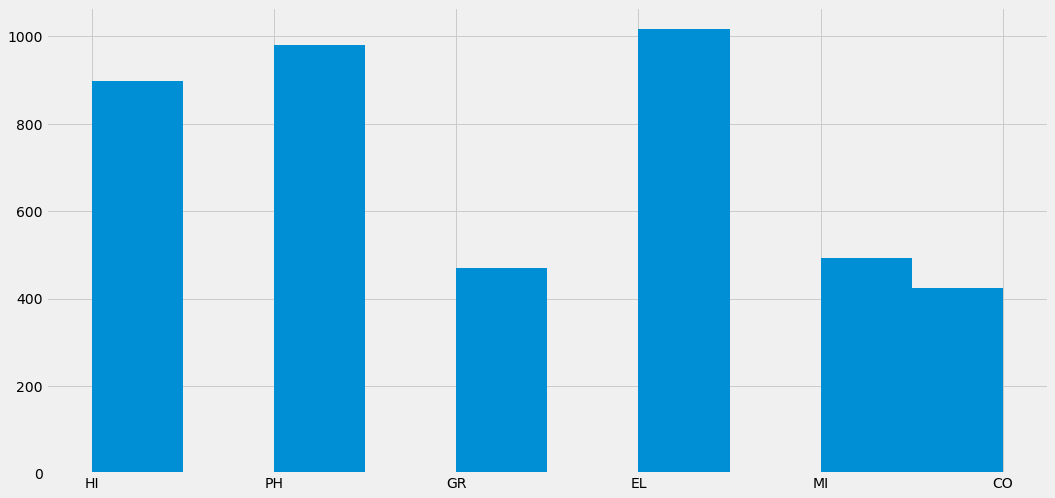

In [5]:
trn[0].value_counts().sort_index()          #정렬 함수> sort_index: 인덱스 기준 정렬 sort_values: 값 기준 정렬
trn[0].hist()                               #종속변수 히스토그램

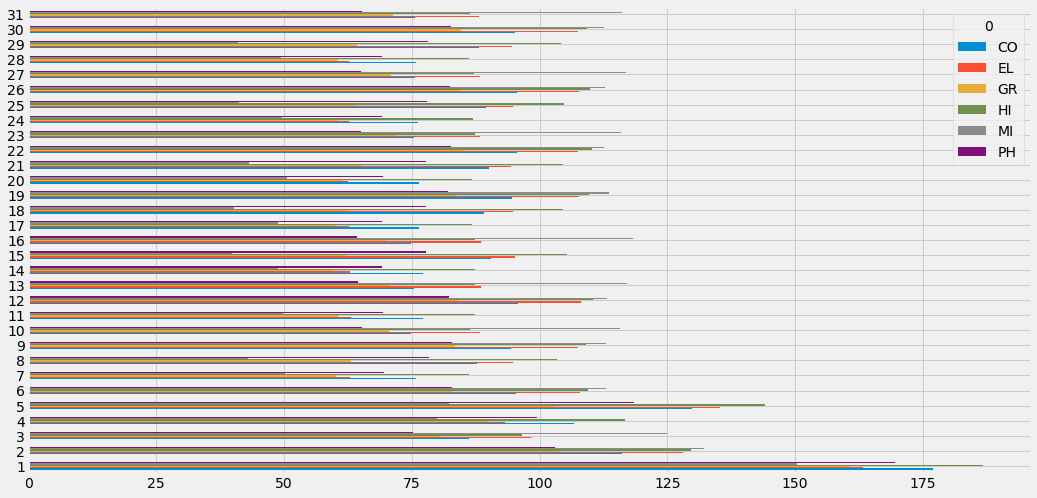

In [6]:
trn.groupby(0).mean().T.plot(kind='barh')

## 독립변수

In [7]:
num_cols = [x for x in trn.columns if trn[x].dtype in [np.int64, np.float64]]
print(num_cols)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


## 독립변수 분포 시각화 

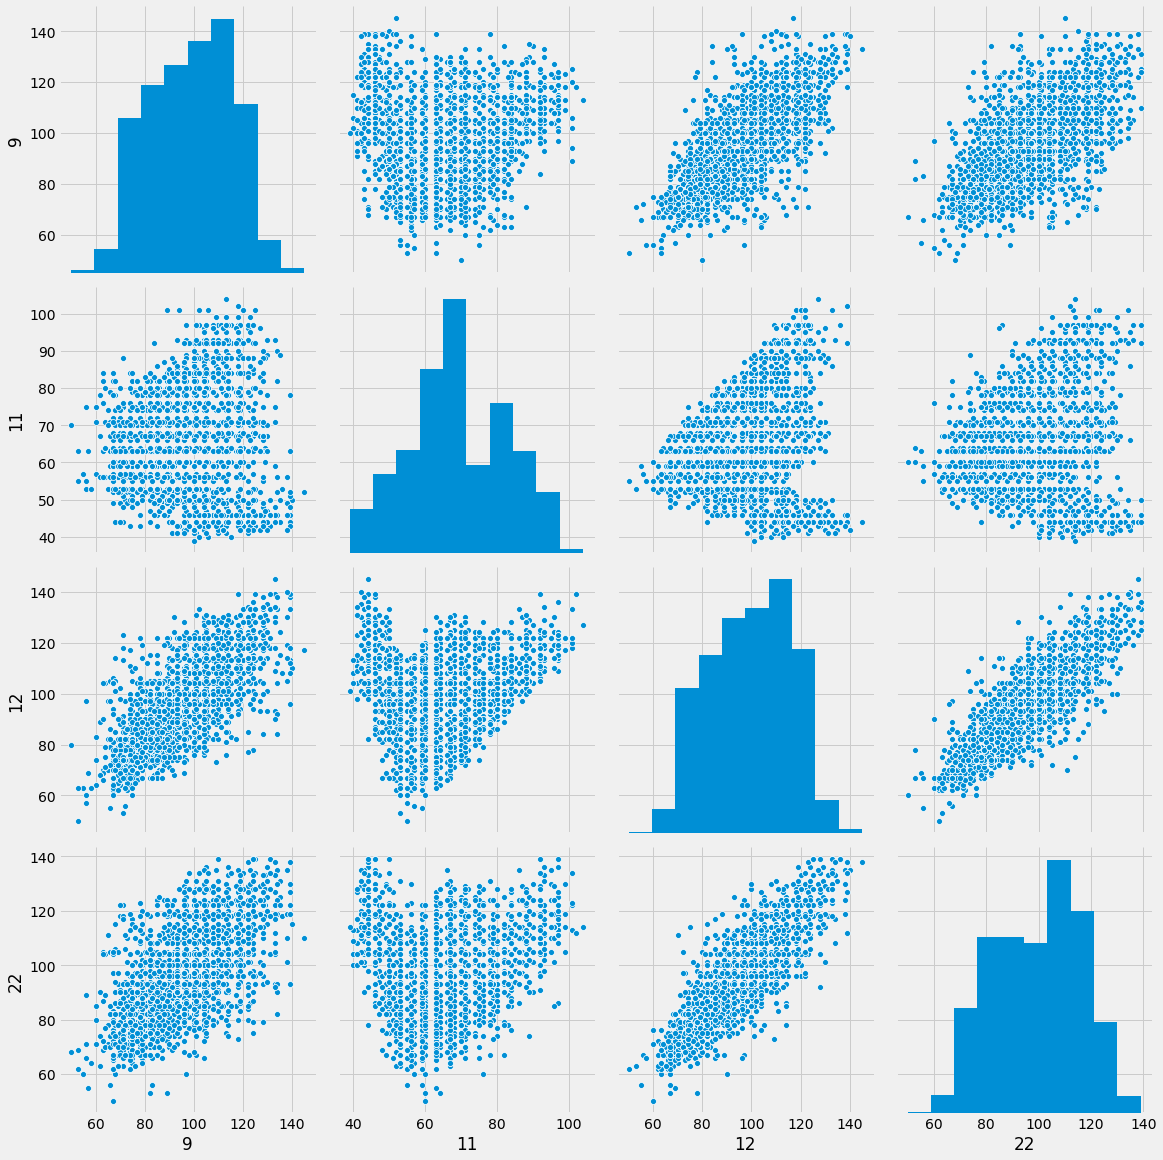

In [8]:
sns.pairplot(data=trn, vars=num_cols[8:9]+num_cols[10:12]+num_cols[21:22], size=4)#정규분포

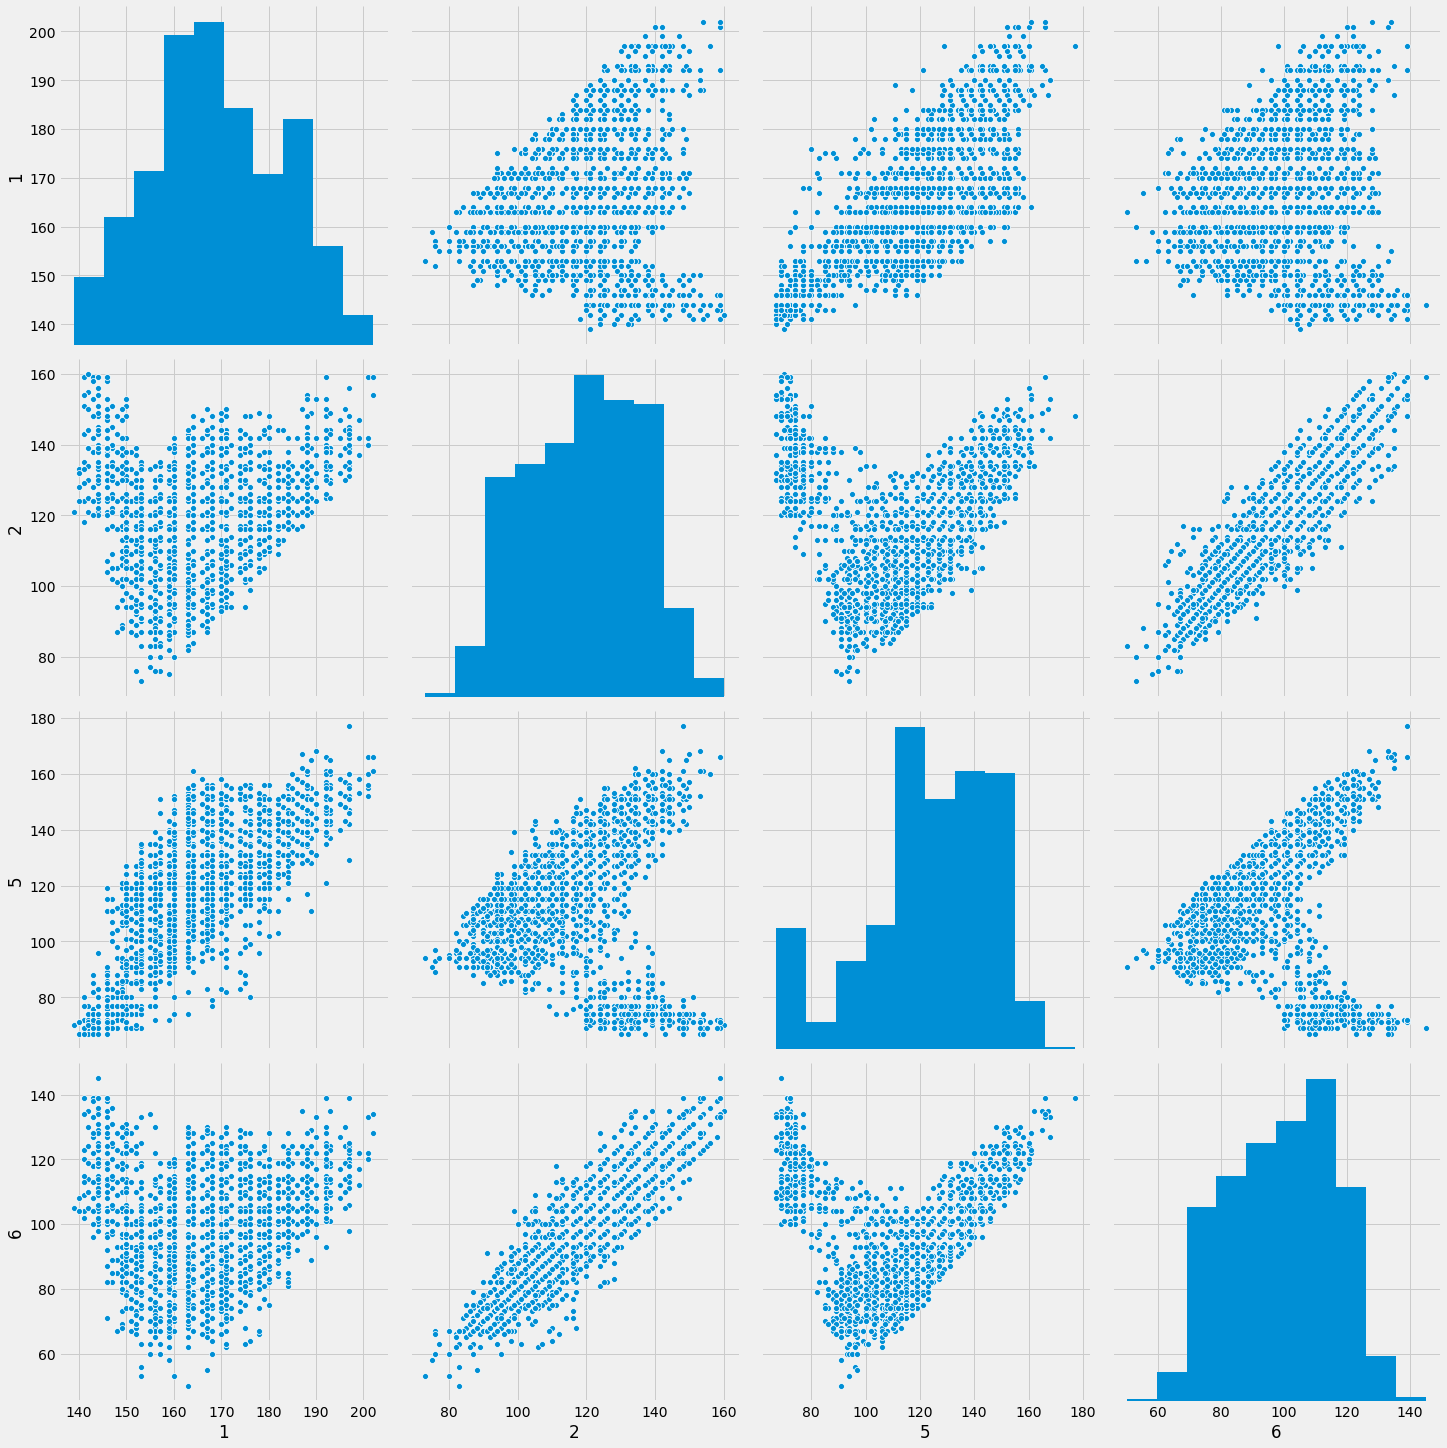

In [9]:
sns.pairplot(data=trn, vars=num_cols[:2]+num_cols[4:6], size=5)#정규분포

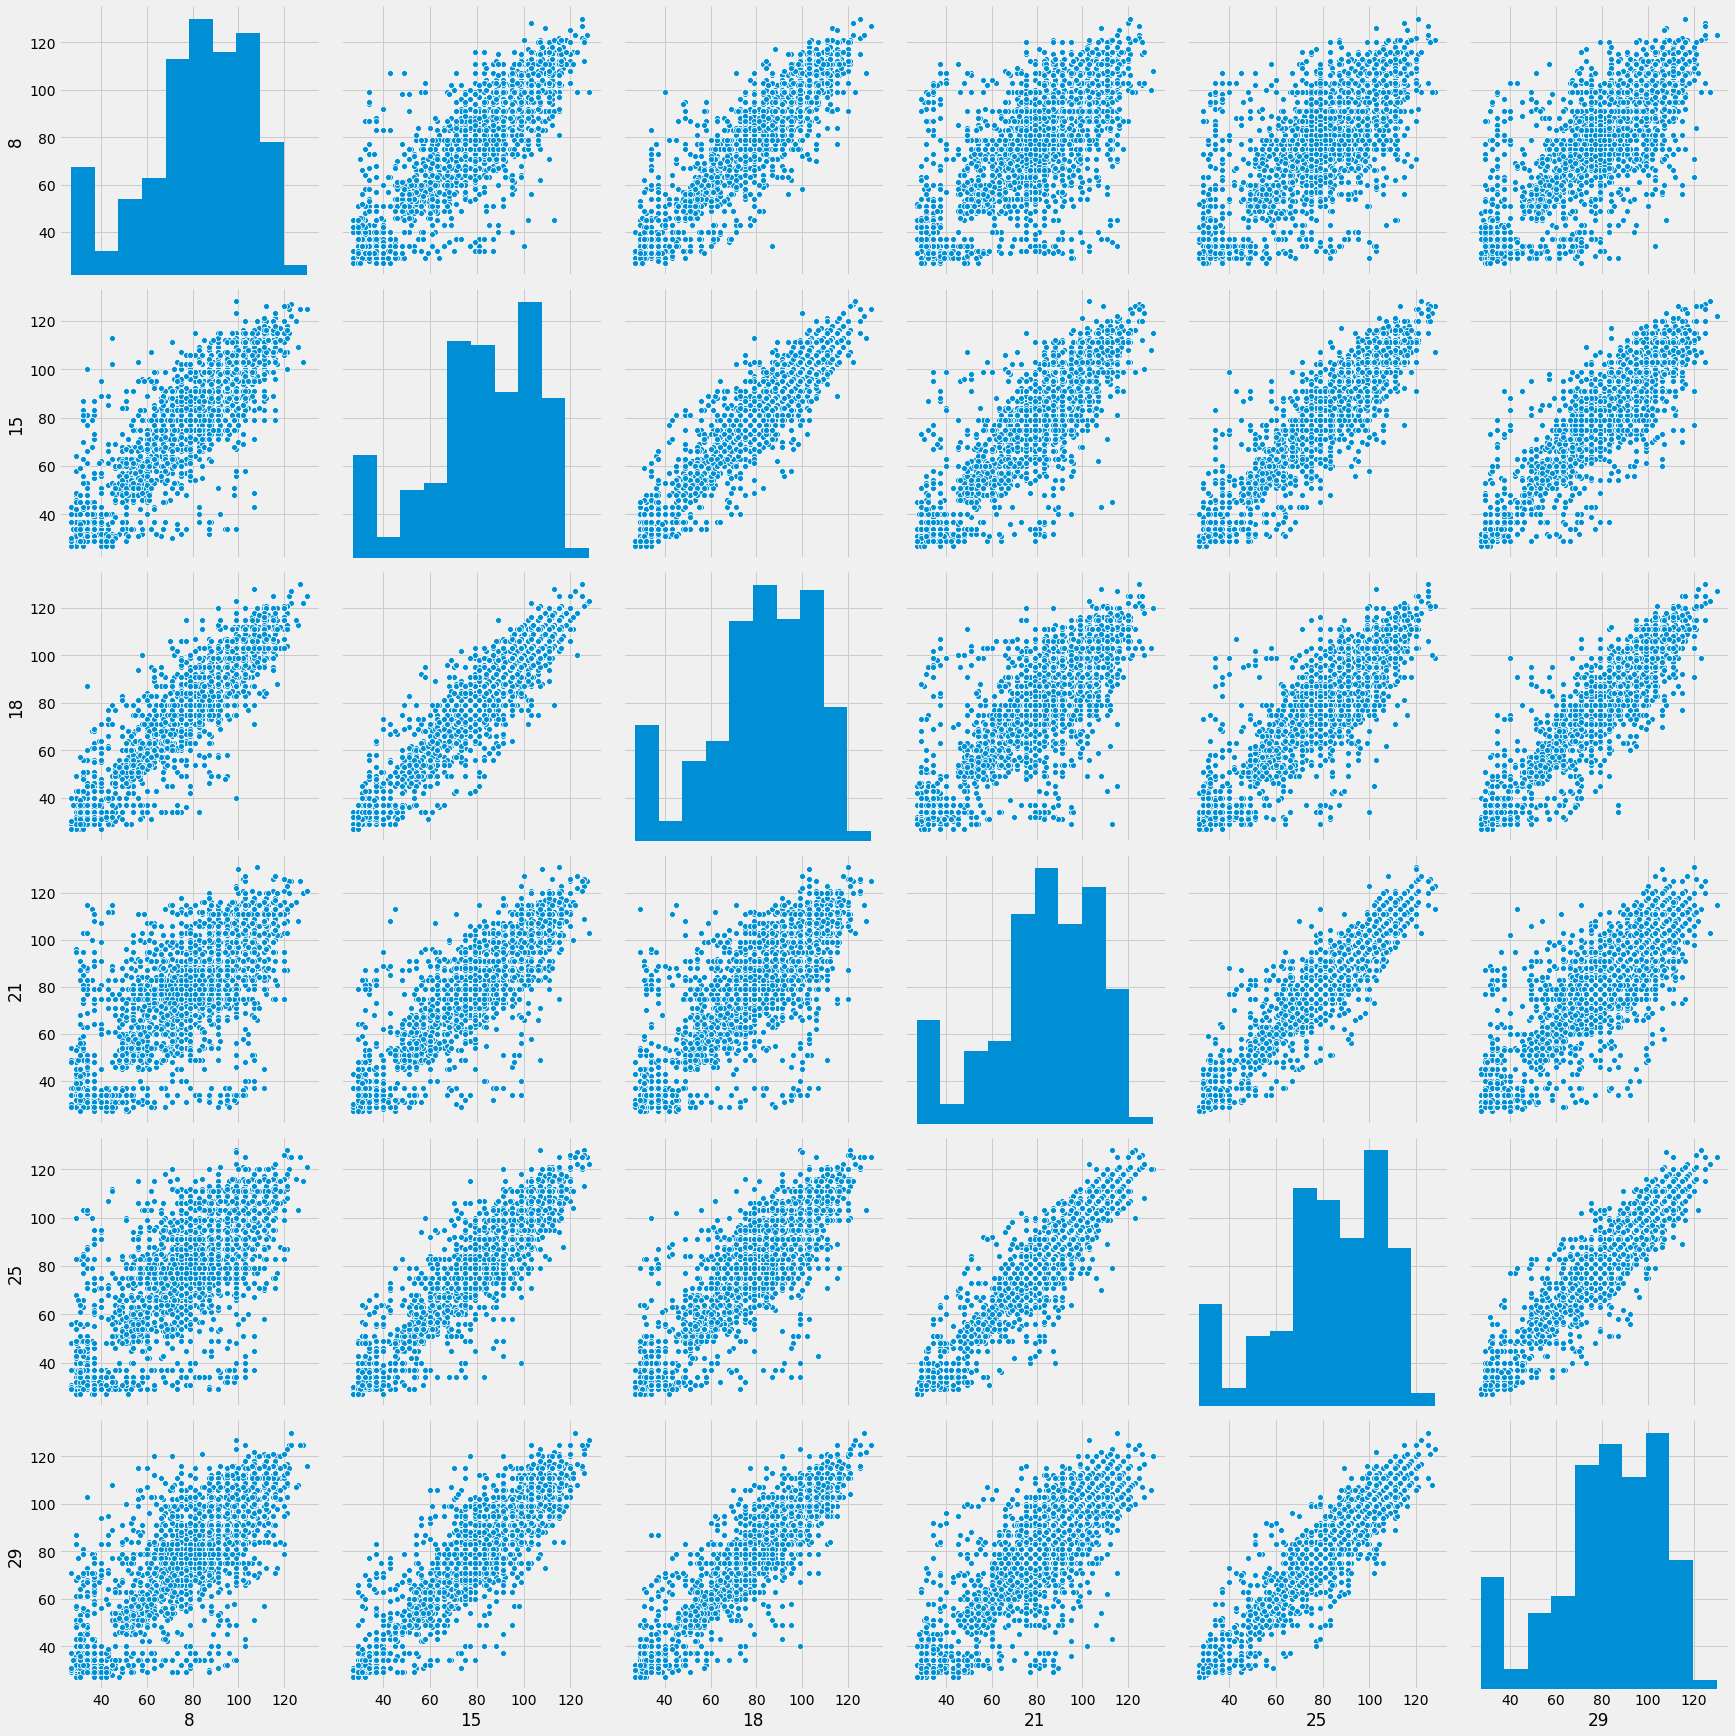

In [10]:
sns.pairplot(data=trn, vars=num_cols[7:8]+num_cols[14:15]+num_cols[17:18]+num_cols[20:21]+num_cols[24:25]+num_cols[28:29], size=4)#정규분포

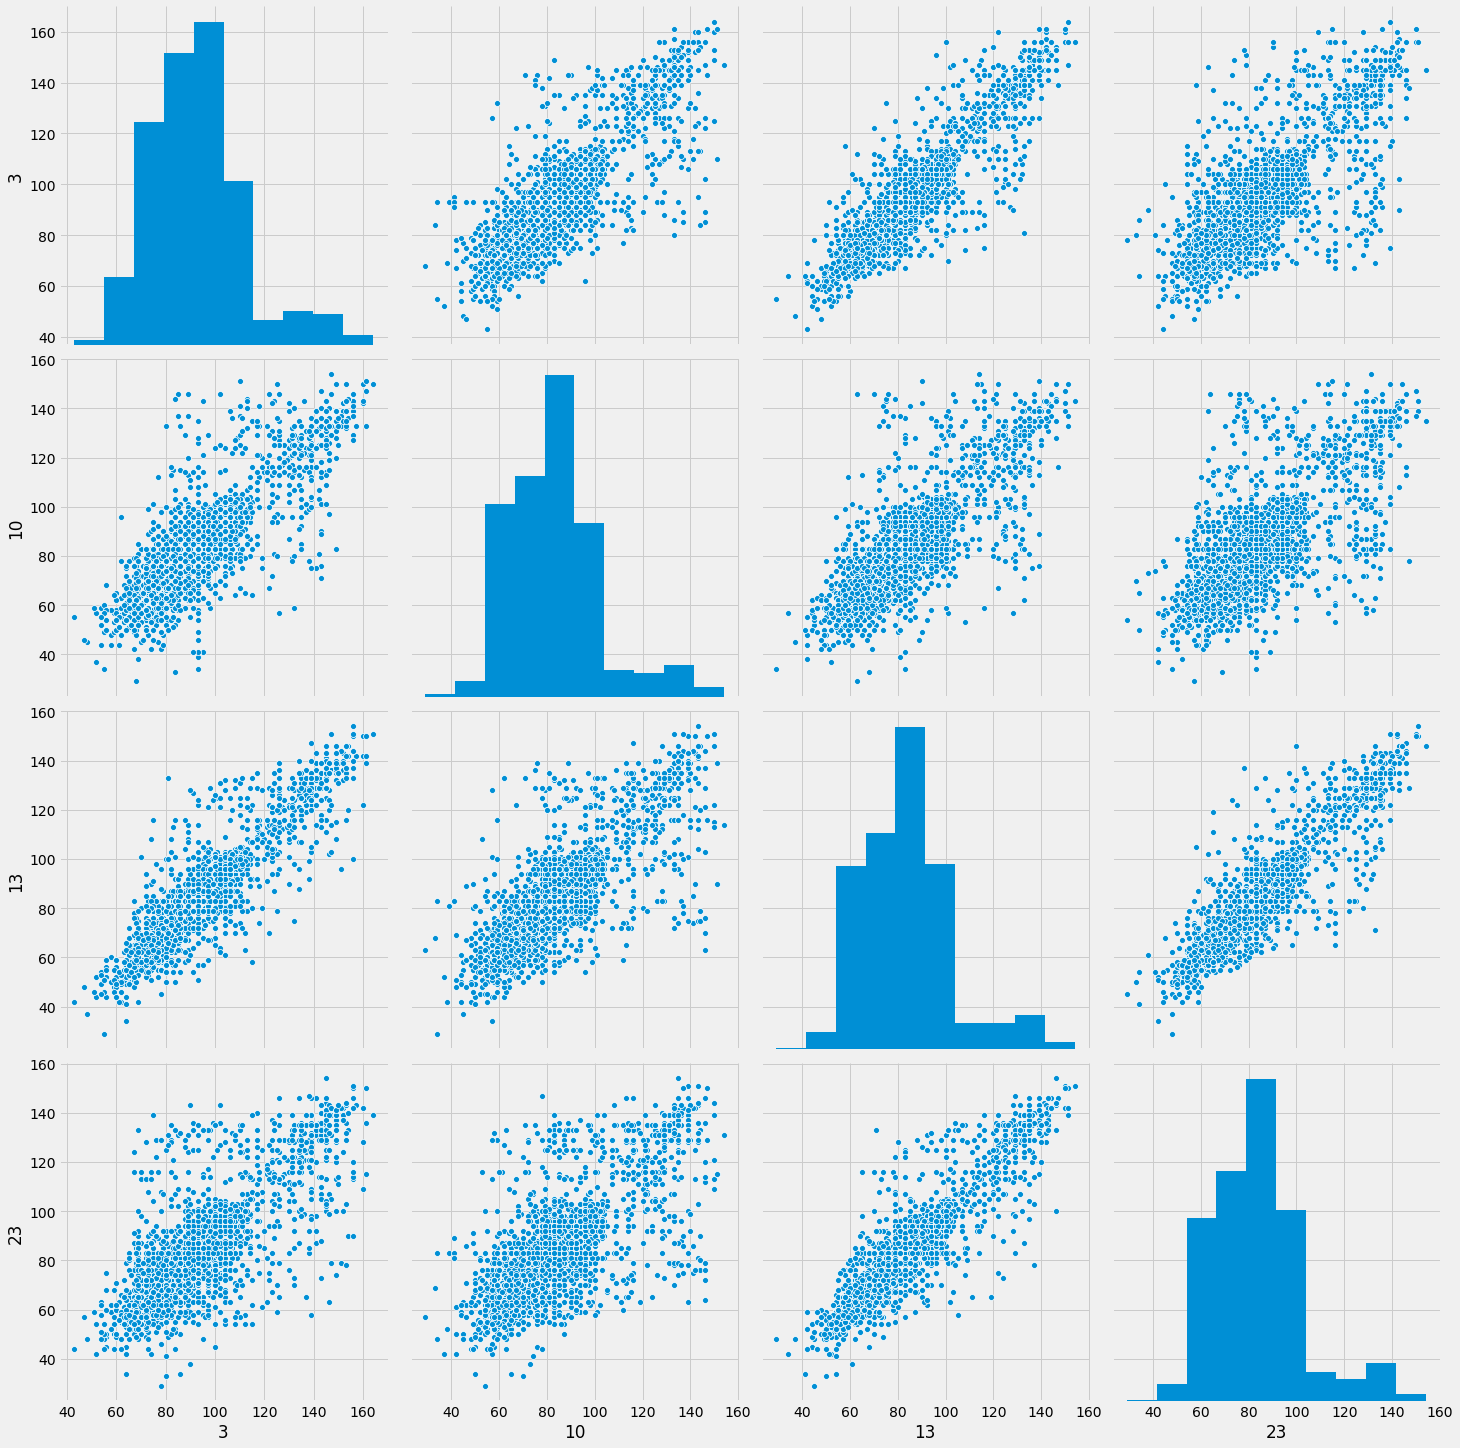

In [11]:
sns.pairplot(data=trn, vars=num_cols[2:3]+num_cols[9:10]+num_cols[12:13]+num_cols[22:23], size=5)#정규분포

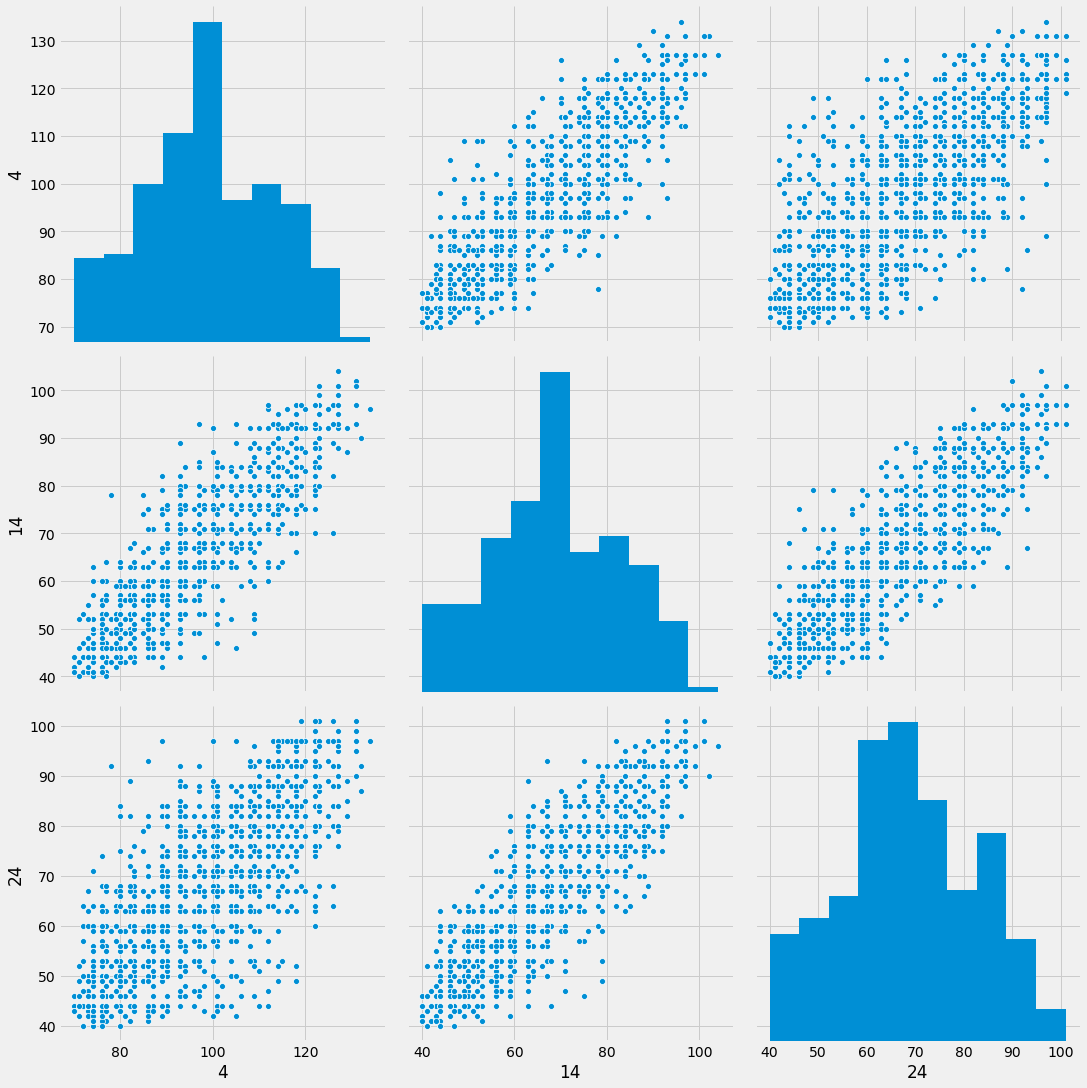

In [12]:
sns.pairplot(data=trn, vars=num_cols[3:4]+num_cols[13:14]+num_cols[23:24], size=5)#정규분포

## 시험 데이터 로드

In [7]:
tst = pd.read_csv(tst_file,header=None)
print(tst.shape)
tst.head()

(1833, 31)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,185,130,100,119,142,110,89,102,114,87,84,106,87,84,102,87,84,106,111,80,95,100,81,84,103,108,88,88,112,113,88
1,178,139,100,104,142,114,63,97,114,94,64,111,91,60,102,91,57,102,115,60,95,108,88,60,95,113,92,53,95,108,88
2,182,125,97,112,137,105,78,97,105,83,84,111,87,84,102,87,84,98,106,80,99,108,85,84,103,108,85,80,99,104,81
3,174,113,83,97,115,89,63,63,82,69,72,82,65,64,73,65,60,66,78,71,75,83,59,64,68,75,63,64,68,83,67
4,167,144,107,97,146,124,67,111,114,101,68,120,98,68,111,102,72,111,120,68,112,122,99,68,107,128,96,71,112,128,99


## 학습/시험 데이터 결합

In [8]:
trn = trn[[ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 0]]
trn.columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,188,128,95,114,143,108,88,103,113,85,88,113,87,88,103,87,84,99,104,82,96,100,78,70,79,84,66,70,75,76,63,HI
1,174,112,88,104,119,92,74,79,88,74,67,90,68,71,73,68,71,77,90,67,71,82,65,70,75,89,73,67,71,89,73,PH
2,175,138,106,105,135,109,75,95,113,96,74,112,96,70,87,100,66,83,117,67,88,110,98,67,88,119,98,75,91,110,94,GR
3,176,111,80,106,131,96,76,99,104,85,75,89,75,79,91,75,84,103,109,82,91,96,78,78,91,96,78,82,104,112,85,PH
4,182,144,111,100,151,119,67,106,114,90,76,115,94,68,106,91,68,102,115,71,95,108,88,71,103,113,92,68,107,118,92,EL


In [9]:
df = pd.concat([trn, tst], axis=0)           #데이터 행열 결함 조건 axis: 0은 위아래로, 1은 가로로 결합
print(df.shape)                              #(6113, 32)
df.tail()

(6113, 32)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
1828,180,120,91,118,143,108,88,107,113,92,88,109,87,93,103,92,88,107,118,78,91,100,81,86,104,112,92,86,100,108,92,NaN
1829,164,142,109,98,147,118,68,112,122,103,71,118,96,71,107,96,71,111,118,66,109,122,96,66,104,122,96,66,113,117,100,NaN
1830,168,95,66,101,115,75,68,75,75,59,67,77,58,67,72,58,67,72,81,70,79,80,63,66,75,80,63,70,79,80,59,NaN
1831,167,98,68,93,115,78,63,71,74,55,64,74,57,64,69,57,64,73,74,68,75,71,56,68,71,75,56,68,71,75,56,NaN
1832,184,124,88,114,135,104,84,103,104,81,84,100,79,84,99,79,84,95,96,82,96,100,78,82,91,100,78,78,87,96,78,NaN


In [10]:
df.fillna(-1, inplace=True)                  #결측값(NaN) -1 로 대체 
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
1828,180,120,91,118,143,108,88,107,113,92,88,109,87,93,103,92,88,107,118,78,91,100,81,86,104,112,92,86,100,108,92,-1
1829,164,142,109,98,147,118,68,112,122,103,71,118,96,71,107,96,71,111,118,66,109,122,96,66,104,122,96,66,113,117,100,-1
1830,168,95,66,101,115,75,68,75,75,59,67,77,58,67,72,58,67,72,81,70,79,80,63,66,75,80,63,70,79,80,59,-1
1831,167,98,68,93,115,78,63,71,74,55,64,74,57,64,69,57,64,73,74,68,75,71,56,68,71,75,56,68,71,75,56,-1
1832,184,124,88,114,135,104,84,103,104,81,84,100,79,84,99,79,84,95,96,82,96,100,78,82,91,100,78,78,87,96,78,-1


In [11]:
df.corr().style.background_gradient()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,1.0000,0.2178,-0.1631,0.9530,0.7743,0.1929,0.8833,0.7102,0.1613,-0.1733,0.9360,0.2007,-0.1675,0.9174,0.7529,-0.1790,0.8629,0.6983,0.1489,0.8543,0.7019,0.1659,-0.1653,0.8512,0.6983,0.1514,-0.1764,0.8213,0.6675,0.1318,-0.1800
1,0.2178,1.0000,0.8650,0.2124,0.3499,0.9348,0.1840,0.3162,0.8468,0.7384,0.1933,0.9099,0.8067,0.1889,0.3311,0.7791,0.1686,0.3060,0.8160,0.1514,0.2974,0.7966,0.7044,0.1494,0.2950,0.7916,0.7003,0.1376,0.2822,0.7583,0.6668
2,-0.1631,0.8650,1.0000,-0.1613,-0.0989,0.8330,-0.1633,-0.1003,0.7607,0.8587,-0.1607,0.8040,0.9212,-0.1659,-0.1003,0.9010,-0.1688,-0.1024,0.7304,-0.1605,-0.0912,0.7020,0.8029,-0.1678,-0.0995,0.7022,0.8055,-0.1751,-0.1046,0.6746,0.7728
3,0.9530,0.2124,-0.1613,1.0000,0.8111,0.2167,0.9525,0.7750,0.1917,-0.1729,0.9099,0.1975,-0.1607,0.9343,0.7725,-0.1711,0.9153,0.7510,0.1752,0.8332,0.6804,0.1648,-0.1564,0.8525,0.6989,0.1617,-0.1661,0.8488,0.6954,0.1494,-0.1766
4,0.7743,0.3499,-0.0989,0.8111,1.0000,0.3632,0.7879,0.9588,0.3371,-0.1088,0.7287,0.3335,-0.0966,0.7591,0.9411,-0.1041,0.7512,0.9272,0.3208,0.6503,0.8268,0.2989,-0.0883,0.6760,0.8535,0.3020,-0.0955,0.6820,0.8589,0.2960,-0.1051
5,0.1929,0.9348,0.8330,0.2167,0.3632,1.0000,0.2079,0.3476,0.9340,0.8160,0.1762,0.8825,0.7864,0.1921,0.3401,0.8063,0.1869,0.3317,0.8852,0.1421,0.2897,0.7856,0.6969,0.1528,0.2996,0.8021,0.7098,0.1485,0.2985,0.7970,0.7043
6,0.8833,0.1840,-0.1633,0.9525,0.7879,0.2079,1.0000,0.8118,0.2114,-0.1713,0.8612,0.1770,-0.1609,0.9081,0.7490,-0.1666,0.9332,0.7716,0.1890,0.7992,0.6482,0.1551,-0.1534,0.8317,0.6773,0.1587,-0.1595,0.8503,0.6962,0.1576,-0.1682
7,0.7102,0.3162,-0.1003,0.7750,0.9588,0.3476,0.8118,1.0000,0.3559,-0.1076,0.6805,0.3096,-0.0955,0.7285,0.9085,-0.0988,0.7593,0.9408,0.3342,0.6166,0.7885,0.2854,-0.0844,0.6500,0.8255,0.2964,-0.0882,0.6753,0.8524,0.3016,-0.0951
8,0.1613,0.8468,0.7607,0.1917,0.3371,0.9340,0.2114,0.3559,1.0000,0.8650,0.1516,0.8298,0.7439,0.1752,0.3205,0.7867,0.1902,0.3358,0.9107,0.1269,0.2682,0.7580,0.6792,0.1437,0.2873,0.7871,0.7005,0.1518,0.2988,0.8046,0.7131
9,-0.1733,0.7384,0.8587,-0.1729,-0.1088,0.8160,-0.1713,-0.1076,0.8650,1.0000,-0.1675,0.7255,0.8382,-0.1653,-0.0982,0.8883,-0.1650,-0.0987,0.8048,-0.1597,-0.0905,0.6646,0.7621,-0.1580,-0.0894,0.6911,0.7898,-0.1616,-0.0906,0.7073,0.8077


## 학습/시험 데이터 저장

In [12]:
df.to_csv('C:\\Users\\USER\\Desktop\\Dataset\\DataInput\\feature.csv')